# Am I the Asshole (AITA) Prediction

The purpose of this project is to 1) find the features most likely to predict who the crowd determines is an asshole, and 2) predict who is in fact an asshole. The data comes from Reddit's AITA subreddit (www.reddit.com/r/AITA).

The data, mostly cleaned here, https://github.com/iterative/aita_dataset/blob/master/aita_clean.csv.dvc, includes the most essential features below. I have added a series of features based on hypotheses, also described below, attempting to discern what is an effective way to guess at assholery. Exploratory data analysis is used to derive relationships between You're The Asshole and Not The Asshole (categorical variable) and the various parameters examined.

All observations are threads (title and body). No information about the poster other than what is in the body is known.

It is more than likely that some people have posted more than once, about different situations; it's fair to say that the number of observations is representative of the number of situations asked about, and not representative of how many people are asking for help from the community (the latter of which we have no number for).

# Data Fields

- id: The unique post ID
- timestamp: The timestamp of the post in datetime (originally in epoch time)
- title: The subject line of the post
- body: The full body of the post
- edited: Whether it was edited or not (T/F)
- verdict: The community's decision ("You're the Asshole" and "Everyone Sucks" both count as being an asshole)
- score: The number of "upvotes" the community gave to that post (roughly, how much interest the community had in that post)
- num_comments: How many people commented on the post
- is_asshole: 1 for yes, 0 for no

# Importing the Data

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np
import datetime

#misc
import gc
import os
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#from nltk.corpus import stopwords
#from nltk.classify import SklearnClassifier


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


#settings
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline


C:\Users\Robert Malka\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r"C:\Users\Robert Malka\Desktop\aita_clean_3.2.csv")

# Exploring the Data

In [3]:
df.head()

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,2014-02-24 21:50:51,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,2014-02-24 22:33:04,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,asshole,140,27.0,1
2,1yu8hi,2014-02-24 23:31:17,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,2014-02-25 00:05:28,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,True,everyone sucks,22,3.0,1
4,1yueqb,2014-02-25 00:29:24,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97628 entries, 0 to 97627
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            97628 non-null  object 
 1   timestamp     97628 non-null  object 
 2   title         97628 non-null  object 
 3   body          97541 non-null  object 
 4   edited        97628 non-null  bool   
 5   verdict       97628 non-null  object 
 6   score         97628 non-null  int64  
 7   num_comments  97628 non-null  float64
 8   is_asshole    97628 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(5)
memory usage: 6.1+ MB


In [5]:
df.dtypes

id               object
timestamp        object
title            object
body             object
edited             bool
verdict          object
score             int64
num_comments    float64
is_asshole        int64
dtype: object

Verifying that there are no typos or missing variables in the data...

In [6]:
#Checking to see if there are any NaN values in e.g. cell 5 of column body. None, which is great.

df['body'].values[5:6]

array(['I love the musical *Les Miserables*. A coworker of mine said that they didn\'t like it. I asked why and they said, among other things, that "it\'s not a musical, it\'s an opera."\n\nNow, I happen to be an opera singer. I told them adamantly that it is NOT an opera. There are a number of things that make this true, but if you can take my word for it- and I hope you can- it\'s not a matter of opinion whether a mainstream musical is an opera or not. It is a musical, period.\n\nMy coworker thought otherwise. "My boyfriend writes musicals and he agrees with me" was the extent of her argument. Well, he may well write musicals but that doesn\'t mean he knows anything about opera. You might as well ask a jazz pianist to tell you about Beethoven- it\'s not the same area of expertise even if it\'s related. I told her "You\'re entitled to your opinion even if it\'s wrong" in a sort-of joking way. Maybe I was being dickish.\n\nI gotta know- am I the asshole?'],
      dtype=object)

In [7]:
df = df.dropna()

In [8]:
#Function that calculates percentage of missing data per column.

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

               column_name  percent_missing
id                      id              0.0
timestamp        timestamp              0.0
title                title              0.0
body                  body              0.0
edited              edited              0.0
verdict            verdict              0.0
score                score              0.0
num_comments  num_comments              0.0
is_asshole      is_asshole              0.0


# Hypotheses & Visualization

## Histogram of is_asshole

### So we know what we're looking at...

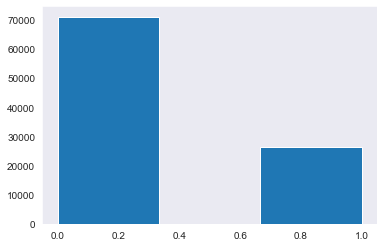

In [9]:
#Categories are '0' and '1'

plt.hist(df['is_asshole'], bins=3);

Interesting! So most of the time, people are NOT considered assholes ('0' (the left side) are not deemed assholes) -- it's actually only about 25,000 of 97,000 people -- or a little more than 25% -- of people who are deemed an asshole in the first place.

# Features

I'm opting to examine some core features of the Title and the Body. They can be described at the following:

- countI: How many times I is said in the body of the text. (Does number of "I"s correlate with narcissism/being an asshole?)
- countHeSheThey: How many times He/She/They is said in the body of the text. (Does number of times OP (original poster) mentions others correlate in either direction to being an asshole (being thoughtful, or placing blame on others)?
- IvsHeSheThey: countI divided by countHeSheThey. Does any proportion between these two numbers suggest being/not being an asshole?
- post_word_count: The length of the post.
- questionmarklast: Whether or not the post ends in a question mark (does asking versus saying, in this case, the last sentence, suggest a humility or arrogance?).
- WIBTA_phrasing: Whether the title asks "Would I be the asshole" versus:
- AITA_phrasing: Whether the title asks "Am I the asshole" -- are there any differences in judgment based on choosing one or the other?

In [10]:
df['countI'] = df.body.str.count("I|I'm")


In [11]:
df['countHeSheThey'] = df.body.str.count("[Tt]hey|[Hh]e|[Ss]he")


In [12]:
df['IvsHeSheThey'] = df.body.str.count("I|I'm") / df.body.str.count("they|he|she")
df['IvsHeSheThey'] = np.where(df.IvsHeSheThey.isin([np.inf, -np.inf]), df['countI'], df['IvsHeSheThey'])


#Have to check out if the lowest and highest fractions correlate at all with assholery. Will look at the 
#distribution and see the points. It's continuous so we should be able to see some interesting outliers.

In [13]:
df = df[df['body'].notnull()]

df['post_word_count'] = [len(item.split()) for item in df['body'].values]

In [14]:
df['questionmarklast'] = df.body.str.endswith('?')

df["questionmarklast"] = df["questionmarklast"].astype(int)

In [15]:
df['WIBTA_phrasing'] = df.title.str.contains("WIBTA|Would I be the asshole", regex=True)
df['AITA_phrasing'] = df.title.str.contains("AITA|Am I the asshole", regex=True)

df["WIBTA_phrasing"] = df["WIBTA_phrasing"].astype(int)
df["AITA_phrasing"] = df["AITA_phrasing"].astype(int)

#write function using .apply to combine WIBTA, AITA, neither.
#apply based on other columns too if needed, row-based apply.

In [49]:
df['IvsHeSheThey'] = df['IvsHeSheThey'].fillna(value=0)

print(missing_value_df)

                       column_name  percent_missing
id                              id         0.000000
timestamp                timestamp         0.000000
title                        title         0.000000
body                          body         0.000000
edited                      edited         0.000000
verdict                    verdict         0.000000
score                        score         0.000000
num_comments          num_comments         0.000000
is_asshole              is_asshole         0.000000
countI                      countI         0.000000
countHeSheThey      countHeSheThey         0.000000
IvsHeSheThey          IvsHeSheThey         0.097395
post_word_count    post_word_count         0.000000
questionmarklast  questionmarklast         0.000000
WIBTA_phrasing      WIBTA_phrasing         0.000000
AITA_phrasing        AITA_phrasing         0.000000


In [17]:
df.describe()

,score,num_comments,is_asshole,countI,countHeSheThey,IvsHeSheThey,post_word_count,questionmarklast,WIBTA_phrasing,AITA_phrasing
count,97541.000000,97541.000000,97541.000000,97541.000000,97541.000000,97446.000000,97541.000000,97541.000000,97541.000000,97541.000000
mean,324.838099,85.332168,0.271383,18.017921,33.978348,0.651817,337.229575,0.453307,0.171979,0.818804
std,1965.611905,312.535658,0.444676,11.427630,21.317624,0.461735,183.968386,0.497818,0.377364,0.385182
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,14.000000,0.000000,10.000000,19.000000,0.388889,203.000000,0.000000,0.000000,1.000000
50%,10.000000,23.000000,0.000000,16.000000,30.000000,0.566038,309.000000,0.000000,0.000000,1.000000
75%,37.000000,46.000000,1.000000,24.000000,45.000000,0.800000,452.000000,1.000000,0.000000,1.000000
max,59187.000000,11906.000000,1.000000,286.000000,689.000000,18.000000,5507.000000,1.000000,1.000000,1.000000


# Cramers V + Heatmap

In [52]:
#Cramer's V test to see correlation between categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [53]:
cramers_list = [df['edited'],
                df['countI'], 
                df['countHeSheThey'], 
                df['IvsHeSheThey'], 
                df['post_word_count'], 
                df['questionmarklast'], 
                df['WIBTA_phrasing'],
                df['AITA_phrasing'],
               ]

list_cramers_names = ['Edited', 'CountI', 'CountHeSheThey', 'post_word_count', 'questionmarklast', 
                      'WIBTA_phrasing', 'AITA_phrasing']

In [20]:
#Need to fix this. so what we're seeing the value of is accurately reflected here.


def cramers_loop(x):
    y = df['is_asshole']

    for i in range(1): #list comprehension here?
    
        for x in cramers_list:
            print("The Cramers V value of {} over is_asshole is {}".format(list_cramers_names[i], 
                                                                       cramers_v(x, y))) 
        
print(cramers_loop(cramers_list))


The Cramers V value of Edited over is_asshole is 0.09484269395353913
The Cramers V value of Edited over is_asshole is 0.034829556030657856
The Cramers V value of Edited over is_asshole is 0.03005672289409666
The Cramers V value of Edited over is_asshole is 0.0
The Cramers V value of Edited over is_asshole is 0.053900686412055226
The Cramers V value of Edited over is_asshole is 0.04587681872399618
The Cramers V value of Edited over is_asshole is 0.022066343891461053
The Cramers V value of Edited over is_asshole is 0.02148630877720569
None


Interesting! So while the correlation for virtually all of them is pretty low, it's interesting to note that whether or not the OP edited their post is correlated with an increased likelihood of being an asshole. Just to be thorough, we see something similar with the heatmap:

In [21]:
#Calculate the correlation coefficients
corr = df.corr(method='pearson', min_periods=1) 
#plot it in the next line
corr.round(2).style.background_gradient(cmap='coolwarm')

,edited,score,num_comments,is_asshole,countI,countHeSheThey,IvsHeSheThey,post_word_count,questionmarklast,WIBTA_phrasing,AITA_phrasing
edited,1.000000,0.070000,0.100000,0.090000,0.140000,0.120000,-0.000000,0.150000,-0.380000,0.020000,-0.010000
score,0.070000,1.000000,0.840000,-0.010000,0.050000,0.060000,-0.020000,0.060000,-0.030000,-0.030000,0.030000
num_comments,0.100000,0.840000,1.000000,0.040000,0.060000,0.060000,-0.010000,0.070000,-0.030000,-0.040000,0.040000
is_asshole,0.090000,-0.010000,0.040000,1.000000,-0.020000,-0.020000,-0.000000,-0.030000,-0.050000,-0.020000,0.020000
countI,0.140000,0.050000,0.060000,-0.020000,1.000000,0.640000,0.200000,0.800000,-0.070000,-0.050000,0.060000
countHeSheThey,0.120000,0.060000,0.060000,-0.020000,0.640000,1.000000,-0.350000,0.900000,-0.060000,-0.040000,0.050000
IvsHeSheThey,-0.000000,-0.020000,-0.010000,-0.000000,0.200000,-0.350000,1.000000,-0.160000,-0.000000,0.020000,-0.010000
post_word_count,0.150000,0.060000,0.070000,-0.030000,0.800000,0.900000,-0.160000,1.000000,-0.080000,-0.040000,0.050000
questionmarklast,-0.380000,-0.030000,-0.030000,-0.050000,-0.070000,-0.060000,-0.000000,-0.080000,1.000000,-0.010000,0.020000
WIBTA_phrasing,0.020000,-0.030000,-0.040000,-0.020000,-0.050000,-0.040000,0.020000,-0.040000,-0.010000,1.000000,-0.960000


## Hypothesis One

  1) How many times we see "I" in a post as correlated with the judgment of YTA/NTA.
  1a) Contrast that with number of times we see "they, she, he" in the same posts.  
  
 - Two-sided Hypothesis: 
   1) The greater the number of I's relative to other pronouns, the more likely a person will be considered an 
   Asshole. 
        - That frequency of self-reference correlates with self-centeredness, which means increased assholery.
   2) The fewer the number of I's relative to other pronouns, the less likely a person will be considered an 
   Asshole.
        - That rarity of self-references correlates with consideration of others, which means decreased assholery.
    

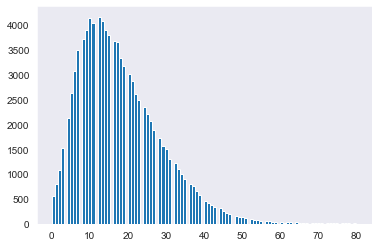

In [22]:
plt.hist(df['countI'], bins=100, range=(0, 80));
plt.xlabel = ('Number of I\'s')
plt.ylabel = ('Number of posts with given I count')
plt.title = ('CountI')
plt.show()

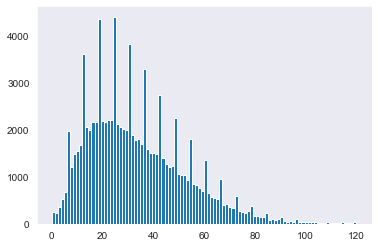

In [23]:
plt.hist(df['countHeSheThey'], bins=100, range=(0, 120));
plt.xlabel = ('Number of Hes/Shes/Theys')
plt.ylabel = ('Number of posts with given HST count')
plt.title = ('CountHeSheThey')

#Notice the occasional jumps -- there are a few numbers of Hes/Shes/Theys that, combined, are extraordinarily
#common for posts, hence why many of the bars jump out far past the skewed curve.

(0.0, 120.0)

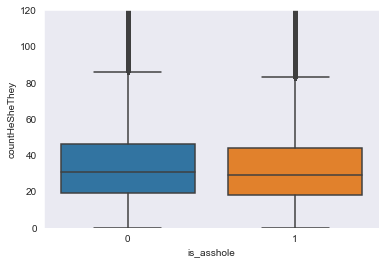

In [24]:
#No significant difference observed in count of HeSheThey vs assholery, as also suggested by our Cramers V review.

ax2 = sns.boxplot(x="is_asshole", y="countHeSheThey", data=df)
plt.ylim(0,120)

(0.0, 2.0)

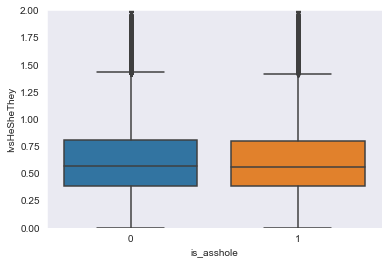

In [25]:
ax3=sns.boxplot(x="is_asshole", y="IvsHeSheThey", data=df)
plt.ylim(0,2)

#no apparent significance in the relationship

## Hypothesis Two

2) Length of post relative to YTA/NTA (which might tell us how much justification a person applied to their 
situation, or how invested they are, etc. -- still considering how to expose any insights using this data.

Possible Hypotheses if we see any significance: 
    1) level of thoughtfulness committed to a situation (positive); 
    2) level of self-rationalization about a situation (negative). 
     

(0.0, 1000.0)

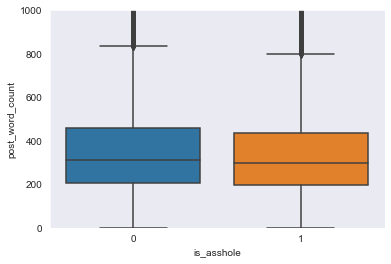

In [63]:
#boxplot to check post length vs is_asshole

ax4 = sns.boxplot(x="is_asshole", y="post_word_count", data=df)
plt.ylim(0,1000)

#There is a very slight observable difference in median length and not being an asshole - but this may turn out
#not to be useful.

#Intuitively, one suspects that, if there *is* any genuine relationship here, it'd be the first resultant 
#hypothesis - that the person is more thoughtful about their situation, having explained more and considered the
#nuances of it more seriously. 

#It could also be that longer posts mean more nuance is given to the audience, who, with more information, are
#more likely to see the gray area (which leans them towards 'no' rather than 'yes.')

In [60]:
#here we're curious to see if an increase in the number of "I"'s relative to post count suggests an increased
#tendency towards assholery.

df['IoverPostCount'] = df.countI / df.post_word_count

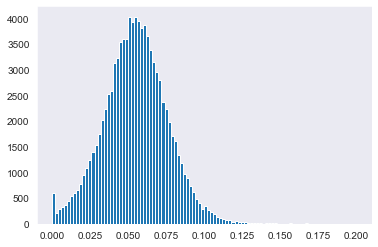

In [28]:
plt.hist(df['IoverPostCount'], bins=100, range=(0,0.2));

(0.0, 0.125)

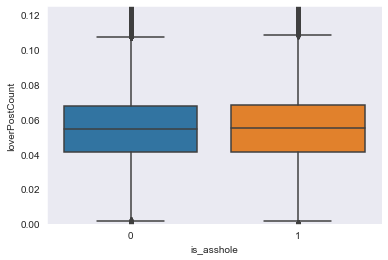

In [29]:
#on its own there's no significant difference, but...

ax5=sns.boxplot(x="is_asshole", y="IoverPostCount", data=df)
plt.ylim(0,0.125)

In [62]:
#let's see if the bottom and top quantiles of this piece lend themselves to percentages relative to is_asshole.

print("The mean of 'IoverPostCount' is", df['IoverPostCount'].mean(), ".")

print("The bottom quantile of 'IoverPostCount' is", df['IoverPostCount'].quantile(q=0.2), ".")
print("The top quantile of 'IoverPostCount' is", df['IoverPostCount'].quantile(q=0.8), ".")


IoPC_quantilelow = df['IoverPostCount'].quantile(q=0.2)
IoPC_quantilehigh = df['IoverPostCount'].quantile(q=0.8)

#how to get all the values below & above this sum and see whether or not they're assholes?


The mean of 'IoverPostCount' is 0.054849911415924914 .
The bottom quantile of 'IoverPostCount' is 0.0379746835443038 .
The top quantile of 'IoverPostCount' is 0.07142857142857142 .


## Hypothesis Three

3) Whether or not the post ends with a question mark (asking for feedback from the crowd, versus making a statement of some kind. Of course possible that they didn't put the "?" down and were asking the question).

Hypotheses: 
    1) That asking a question shows an openness to being wrong (and thus suggests they're less likely to 
be an asshole), whereas 
    2) Making a statement (period or no punctuation) at the end of their evaluation shows a disregard for the 
    crowd, leading to a greater possibility that they'll be evaluated as an asshole.


(array([53325.,     0., 44216.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

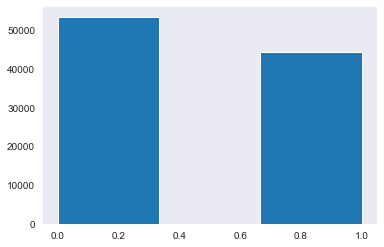

In [77]:
plt.hist(df['questionmarklast'], bins=3)

(0.0, 2.0)

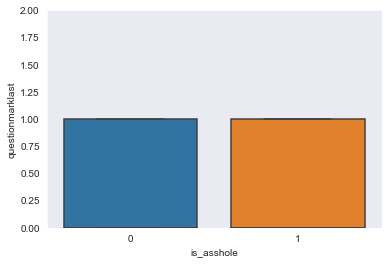

In [78]:
ax6=sns.boxplot(x="is_asshole", y="questionmarklast", data=df)
plt.ylim(0,2)

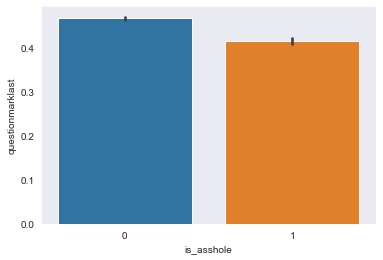

In [79]:
#We see a significant difference here! People who ask a question at the end of their post (often "Am I the
#asshole?") are less likely to be judged an asshole. The correlation is interesting, but in no way conclusive.

ax6=sns.barplot(x="is_asshole", y="questionmarklast", data=df)

## Hypothesis Four

5) We're looking at "Would I be the asshole" vs "Am I the asshole?"

Hypothesis: The conditional suggests a person who is more cautious, which means a person who is less likely 
to engage in assholery.

Null Hypothesis: There is no correlation between the hypothetical phrasing and the "actual" phrasing.


(array([80766.,     0., 16775.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

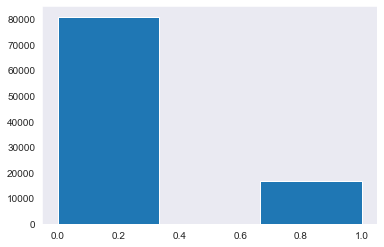

In [80]:
plt.hist(df['WIBTA_phrasing'], bins=3)

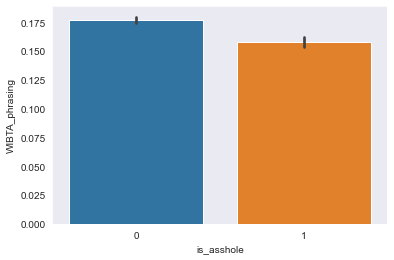

In [85]:
sns.barplot(x='is_asshole', y='WIBTA_phrasing', data=df)

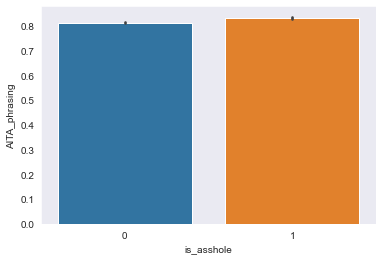

In [84]:
sns.barplot(x='is_asshole', y='AITA_phrasing', data=df)

(array([17674.,     0., 79867.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

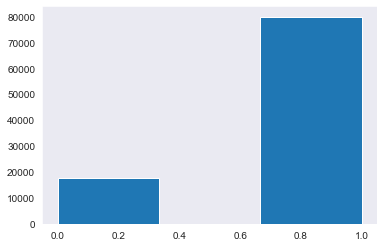

In [83]:
plt.hist(df['AITA_phrasing'], bins=3)

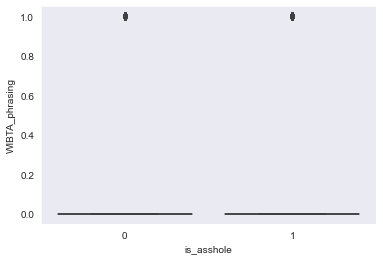

In [86]:
#what the fuck is this

ax7 = sns.boxplot(x="is_asshole", y="WIBTA_phrasing", data=df)


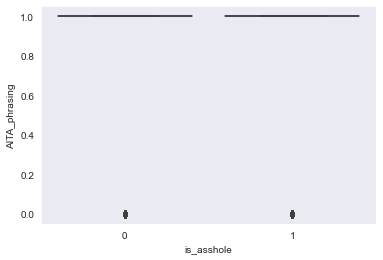

In [87]:
ax8 = sns.boxplot(x="is_asshole", y="AITA_phrasing", data=df)


## Hypothesis Five

Do we see a difference in likelihood of assholery based on whether or not a subject is with regards to any of the following categories? 

I suspect we'll see it as a higher likelihood in romantic relationships, and likely lower in professional concerns.

3) Categorizing data (through title) under four broad headings: 
  3a) Romantic Relationships
  	- Described using word embeddings: "My Boyfriend," "My Girlfriend," "My Partner," &c. 
  3b) Familial Disagreement 
    - "My Mom, Sister, Dad, Grandma, Grandpa, Grandparents, Brother, Cousin," &c
  3c) Professional Concerns 
    - "My Boss, My co-worker, My Colleague", &c.
  3d) None of the Above (Miscellaneous)

In [67]:
#Doing the following:
# - converting the subject line ("title") into a bag-of-words
# - vectorizing the individual words
# - applying a naive bayes model to it in a test-run, just to see how predictive individual words are with respect
# to assholery.

#It cannot be emphasized enough: This DOES NOT have ANY correlation with the actual meaning and context these words
#have with their usage (it says nothing about WHY or WHAT IT MEANS that these words are correlated with being an
#asshole - it only suggests that in these particular instances, in the context of this or that culture at this
#particular time, these words have a higher correlation with assholery.)


def make_xy(df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.title)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.is_asshole.values.astype(np.int)
    return X, y
X, y = make_xy(df)

In [32]:
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed in as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [33]:
_, itest = train_test_split(range(df.shape[0]), train_size=0.7)
mask = np.zeros(df.shape[0], dtype=np.bool) #look this up more - this makes an array of zeros - for those rows 
                                            #in the itest of 1, make it true (so there's a bunch of trues and 
                                            #falses)
mask[itest] = True

In [34]:
best_alpha = 0.05

vectorizer = TfidfVectorizer(tokenizer=None,
               min_df=30, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 ) #look up what this means tfidf here.
X, y = make_xy(df, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

#x matrix becomes # of times likely to appear, and y matrix is yes/no

# adding ngram_range=(1, 2) to tfidf vectorizer increases accuracy on training data to 88% but reduces
# accuracy on test data to 68.6% (still higher than count vectorizer).

#The model beats chance - especially since one only has a 25% chance of being considered an asshole, and the 
#amount of words used in a title is roughly consistent:

Accuracy on training data: 0.746024
Accuracy on test data:     0.696169


In [68]:
lens = df.title.str.len()
lens.mean(), lens.std(), lens.max()

(63.669995181513414, 25.193879845266235, 300)

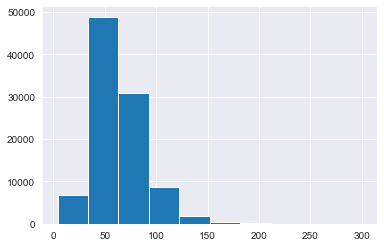

In [69]:
#Cool, vast majority between ~50 & 100 words.

lens.hist()

In [72]:
#so that said, let's check out what these good + bad words are.

words = np.array(vectorizer.get_feature_names())

x = len(words)

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:1000]]
bad_words = words[ind[-1000:]]

good_prob = probs[ind[:1000]]
bad_prob = probs[ind[-1000:]]

print("Good words\t     P(is_asshole | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(is_asshole | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

words = np.array(vectorizer.get_feature_names())


Good words	     P(is_asshole | word)
          experience 0.84
             flowers 0.76
          disclosing 0.71
     unintentionally 0.71
             revenge 0.70
       intentionally 0.69
                lane 0.69
               foods 0.66
               items 0.65
           standards 0.65
            implying 0.65
            expenses 0.64
                 air 0.64
         performance 0.63
             mocking 0.62
             failing 0.61
                owed 0.61
               reach 0.61
              leaves 0.60
               field 0.60
              loudly 0.60
        overreacting 0.60
            spoiling 0.60
              system 0.59
                case 0.59
              jacket 0.59
               dirty 0.59
             furious 0.59
                fear 0.59
                poor 0.59
               named 0.59
        deliberately 0.59
               empty 0.58
                huge 0.58
                keys 0.57
            american 0.57
               daddy 0.57
 

              sports 0.30
                 low 0.30
             posting 0.30
                team 0.30
               might 0.30
                rest 0.30
                xmas 0.30
           reminding 0.30
             refuses 0.30
             teacher 0.30
            addicted 0.30
                  as 0.30
              flying 0.30
                 day 0.30
          engagement 0.30
              number 0.30
                wait 0.30
               older 0.30
              delete 0.30
               knows 0.30
               niece 0.30
                 gym 0.30
              liking 0.30
             payment 0.30
            business 0.30
         encouraging 0.30
                dorm 0.30
            planning 0.30
                some 0.30
              thinks 0.30
             hosting 0.30
            probably 0.30
                 19f 0.30
                 key 0.30
            discount 0.30
                pull 0.30
                meme 0.30
                hour 0.30
            

            visiting 0.16
           purchased 0.16
               touch 0.16
                 pic 0.16
         unsolicited 0.16
                 bil 0.16
              sitter 0.16
        disappointed 0.16
               cheap 0.16
                hold 0.16
                 cut 0.16
          distancing 0.16
             locking 0.16
            sexually 0.15
             denying 0.15
           character 0.15
               price 0.15
                kill 0.15
               weeks 0.15
              summer 0.15
             already 0.15
              artist 0.15
            comments 0.15
              travel 0.15
            airplane 0.15
              living 0.15
                 20f 0.15
           emergency 0.15
                gone 0.15
           harassing 0.15
              enough 0.15
           religious 0.15
                 lab 0.15
               lease 0.15
            separate 0.15
             goodbye 0.15
             privacy 0.15
         financially 0.15
            

In [90]:
#let's look at another way to approach assholery, starting with family...


step_isasshole = df[df.title.str.contains('stepbrother|stepmother|stepfather|stepsister')]['is_asshole'].mean()
god_isasshole = df[df.title.str.contains('godmother|godfather')]['is_asshole'].mean()
grand_isasshole = df[df.title.str.contains('grandmother|grandfather|grandpa|grandma|granddad')]['is_asshole'].mean()
parents_isasshole = df[df.title.str.contains('dad|mom|mother|father')]['is_asshole'].mean()
siblings_isasshole = df[df.title.str.contains('brother|sister')]['is_asshole'].mean()
kids_isasshole = df[df.title.str.contains('daughter|son|child|kid')]['is_asshole'].mean()
relatives_isasshole = df[df.title.str.contains('niece|nephew|uncle|aunt|cousin|cousins')]['is_asshole'].mean()


is_asshole_mean = df['is_asshole'].mean()

#don't know how to loop this through the above "list", if I were to make it a list.

print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('stepfamily', step_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('godparents', god_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('grandparents', grand_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('parents', parents_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('siblings', siblings_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('kids', kids_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('relatives', relatives_isasshole, (is_asshole_mean)))



stepbrother_isasshole = df[df.title.str.contains('stepbrother')]['is_asshole'].mean()
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('stepbrother', stepbrother_isasshole, (is_asshole_mean)))


#Have the list below anyway, for kicks:

alltheassholes = [step_isasshole, god_isasshole, grand_isasshole, parents_isasshole, siblings_isasshole, 
                  kids_isasshole, relatives_isasshole]


#Create a column called df['family_issues'] and have it consist of:
    # If words in the list are in the title or body
    # Then True
    # Else
    # False

The likelihood the subject was an asshole if the issue concerned stepfamily is 0.17567567567567569, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned godparents is 0.3684210526315789, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned grandparents is 0.1878589007383101, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned parents is 0.19235340729001585, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned siblings is 0.2571700421367405, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned kids is 0.3187810945273632, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned relatives is 0.227995347033734, versus the gener

In [91]:
step2_isasshole = df[df.body.str.contains('stepbrother|stepmother|stepfather|stepsister')]['is_asshole'].mean()
god2_isasshole = df[df.body.str.contains('godmother|godfather')]['is_asshole'].mean()
grand2_isasshole = df[df.body.str.contains('grandmother|grandfather|grandpa|grandma|granddad')]['is_asshole'].mean()
parents2_isasshole = df[df.body.str.contains('dad|mom|mother|father')]['is_asshole'].mean()
siblings2_isasshole = df[df.body.str.contains('brother|sister')]['is_asshole'].mean()
kids2_isasshole = df[df.body.str.contains('daughter|son|child|kid')]['is_asshole'].mean()
relatives2_isasshole = df[df.body.str.contains('niece|nephew|uncle|aunt|cousin|cousins')]['is_asshole'].mean()


print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('stepfamily', step2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('godparents', god2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('grandparents', grand2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('parents', parents2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('siblings', siblings2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('kids', kids2_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('relatives', relatives2_isasshole, (is_asshole_mean)))


#Can also print the difference in means between what we see when this is filtered through the title and what we see
#when filtered through the body of the post.


The likelihood the subject was an asshole if the issue concerned stepfamily is 0.17729083665338646, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned godparents is 0.25225225225225223, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned grandparents is 0.19883864156255499, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned parents is 0.2299543584831239, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned siblings is 0.23478177641653905, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned kids is 0.2649261137073056, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned relatives is 0.2228524164008035, versus the ge

In [92]:
work_words = ['business partner', 'boss', 'colleague', 'employee', 'staff', 'co-worker']


bus_isasshole = df[df.title.str.contains('business partner|business partners')]['is_asshole'].mean()
boss_isasshole = df[df.title.str.contains('boss|bosses')]['is_asshole'].mean()
coll_isasshole = df[df.title.str.contains('colleague|co-worker|coworker|colleagues|co-workers|coworkers')]['is_asshole'].mean()
employee_isasshole = df[df.title.str.contains('employee|staff')]['is_asshole'].mean()

print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('business partners', bus_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('bosses', boss_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('colleagues', coll_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('employees', employee_isasshole, (is_asshole_mean)))



The likelihood the subject was an asshole if the issue concerned business partners is 0.1111111111111111, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned bosses is 0.22647527910685805, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned colleagues is 0.26474686483975846, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned employees is 0.3223350253807107, versus the general average of 0.2713833157338965.


In [93]:
romance_words = ['partner', 'boyfriend', 'girlfriend', 'hookup', 'sex', 'love', 'affair', 'slept with', 
                'sleeping with']


gfbf_isasshole = df[df.title.str.contains('partner|partners|girlfriend|boyfriend|girlfriends|boyfriends')]['is_asshole'].mean()
drama_isasshole = df[df.title.str.contains('hookup|love|best friend')]['is_asshole'].mean()
cheating_isasshole = df[df.title.str.contains('cheating|affair|slept|slept with|fucked|best friend|sleeping with')]['is_asshole'].mean()
sex_isasshole = df[df.title.str.contains('sex')]['is_asshole'].mean()

print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('romantic partners', gfbf_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('general drama', drama_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('cheating', cheating_isasshole, (is_asshole_mean)))
print("The likelihood the subject was an asshole if the issue concerned {} is {}, versus the general average of {}.".format('sex', sex_isasshole, (is_asshole_mean)))



The likelihood the subject was an asshole if the issue concerned romantic partners is 0.3116923718215923, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned general drama is 0.3033866415804327, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned cheating is 0.31305398871877516, versus the general average of 0.2713833157338965.
The likelihood the subject was an asshole if the issue concerned sex is 0.33368091762252344, versus the general average of 0.2713833157338965.


In [ ]:
#These didn't work... hahahaha

#y = words.tostring()
#z = probs.tostring()

sentiment_dict = {y : z}
print(sentiment_dict)

    
#create new dataframe and numpy array

# put results of for loop into dictionary
# example of how to create sentiment for one word.


#df2 = pd.DataFrame(df['title']) #sentiment analysis


#once the analysis is done, we .append() to the original df as columns (pd.concat <-- safer, or?... pd.merge)


In [ ]:
'''
my_dicts = []

for file in glob.glob('C:/Users/TestCase/Downloads/test/*'): 

    by_color = defaultdict(int)
    im = Image.open(file)
    for pixel in im.getdata():
        by_color[pixel] += 1
    by_color

    # Update the value of each key in a dictionary to 1
    d = {x: 1 for x in by_color}
    # Print the updated dictionary

    check = dict(d)

    print(check) # Print the results from the for loop

    my_dicts.append(check)

print(my_dicts) # Prints the dictionaries stored in a list



    print(check) // Print the results from the for loop

 print(check) // Prints only the last iteration result of for loop
 '''

In [40]:
family_words = ['godmother', 'stepbrother', 'stepmother', 'stepsister', 'stepfather', 'grandpa', 'grandfather', 
                'granddad', 'dad', 'mom', 'father', 'mother', 'son', 'daughter', 'niece', 'nephew', 'uncle', 
                'aunt', 'godfather', 'cousin']


work_words = ['business partner', 'boss', 'colleague', 'employee', 'staff']


romance_words = ['partner', 'boyfriend', 'girlfriend', 'hookup', 'sex', 'love', 'affair', 'slept with', 
                'sleeping with']


df['family_issues'] = [True for x in family_words if x in df.title]
if True in df['family_issues']:
    print('1')
else: 
    print('0')


df.title.str.contains(family_words)

df.title.str.contains(family_words).mean()


df.title.str.contains(work_words)

df.title.str.contains(work_words).mean()

df.title.str.contains(romance_words)

df.title.str.contains(romance_words).mean()



df['work_issues'] = [True for x in family_words if x in df.title]
if True in df['family_issues']:
    print('1')
else: 
    print('0')


df.title.str.contains(work_words)
    

df['romantic_issues'] = [True for x in family_words if x in df.title]
if True in df['family_issues']:
    print('1')
else: 
    print('0')


df.title.str.contains(romance_words)


'''
str = "one two three four five"
isMatch = [True for x in myList if x in str]
if True in isMatch:
  print("some of the strings found in str")
else:
  print("no strings found in str")
    '''

ValueError: Length of values does not match length of index

In [ ]:
#turn dictionary into dataframe
#create features manually by searching thru text, and then say family mentioned.
#Or can weight every word separately... can search text based on string search.
#boosting mechanism - enhancing weight of words, or can create new categories/features/columns
  # find any matching, then can do 1 or 0
    # add column = "family", put 1 or 0 for all related to family
    # add column = "work", put 1 or 0
    
    
    

# Hypothesis Six - What we're measuring:

## This one is still in progress.

6) Looking for adjectives that suggest passion/anger/frustration, and if there's a correlation between valence
and assholery. 

**From there, we look for certain adjectives, which will require a little more sleuthing. We'll take out 
definite and indefinite articles, prepositions, etc.**

"If any of these adjectives are included, then --> YTA/NTA"

Theory:
    That words that suggest a higher emotional valence will indicate a *lesser* inclination for assholery. (Example: "AITA for abandoning my depressed friend?") It shows the writer's self-awareness (they're more interested in writing something that gets a lot of attention/is eye-catching, to validate that they're NOT an asshole).
        
Looking at Subject lines ("title"), ideally in this way through sentiment analysis:

[subject] [adjective with valence] [event with valence], trying to suss out AITA. 



In [ ]:





#you could run a sentiment analysis on the text and then run that as a feature.


In [ ]:
df.to_csv("AITA_EDA_4.0.csv", index=False)

In [ ]:
#Sentence count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#Need to separate into train and test data


#length of subject line ('title') - if we want to see if that has an effect at all.

lens = df.title.str.len()
lens.mean(), lens.std(), lens.max()

In [ ]:
lens.hist()

What we need is something that will look like correlation, but will work with categorical values — or more formally, we’re looking for a measure of association between two categorical features. Cramér’s V is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:

Similarly to correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t.)

Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y.

[[need to have this explained here?]]

Thinking over the output of Cramer’s V, I realized I’m losing valuable information due to the symmetry of it. To better demonstrate that, consider the following data-set:

We can see that if the value of x is known, the value of y still can’t be determined, but if the value of y is known — then the value of x is guaranteed. This valuable information is lost when using Cramer’s V due to its symmetry, so to preserve it we need an asymmetric measure of association between categorical features. And this is exactly what Theil’s U is.

Theil’s U, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between x and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur. Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). Using Theil’s U in the simple case above will let us find out that knowing y means we know x, but not vice-versa.

#No real need to do this since most categories are just true/false (two states)
#Still interesting to see if it gives a similar score, but best to skip it.

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
        
#No real need here, but worth checking out anyway.

def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta
        
correlation_ratio(x, )

Sources I used/examined in figuring code out:

- Hypothesis 1

https://stackoverflow.com/questions/17573814/count-occurrences-of-certain-words-in-pandas-dataframe
https://stackoverflow.com/questions/49230262/how-to-count-uppercase-and-lowercase-on-pandas-dataframe
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.html
https://stackoverflow.com/questions/18355416/matplotlib-pyplot-hist-returns-a-histogram-where-all-bins-have-the-same-value-wh
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.count.html


Sources I used/examined in coding Hypothesis 2:

https://stackoverflow.com/questions/37483470/how-to-calculate-number-of-words-in-a-string-in-dataframe
https://stackoverflow.com/questions/17573814/count-occurrences-of-certain-words-in-pandas-dataframe
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
https://stackoverflow.com/questions/52552066/dask-compute-gives-attributeerror-series-object-has-no-attribute-encode/52553957#52553957
https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas


Sources I used for Hypothesis 3:

https://www.kaggle.com/kakiac/sentiment-analysis-with-nltk
https://stackoverflow.com/questions/47125665/simple-dask-map-partitions-example
https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c
https://www.reddit.com/r/datascience/comments/8qde2g/sentiment_analysis_in_python_any_pretrained_models/
https://github.com/openai/generating-reviews-discovering-sentiment
http://nlp.town/blog/off-the-shelf-sentiment-analysis/ a fun little blog
https://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html explaining how VADER works
https://towardsdatascience.com/text-classification-with-state-of-the-art-nlp-library-flair-b541d7add21f if I want to use flair instead of VADER
https://pypi.org/project/wordcloud/



Sources I investigated for Hypothesis 4:

https://thispointer.com/check-the-first-or-last-character-of-a-string-in-python/
https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe


## Need to:

#### Preprocess text data -- nlp briefing, clean text data for numeric conversion.
  ##### Removing text characters, noise, &c. things you might need to do before doing bag of words DONE
#### Use bag of words to convert text to numeric vector.
  ##### Word embeddings is another way (more complicated than bag of words)
#### Then you can apply k-means clustering to those vectors
  ##### Can check which of the text forms under this k-means cluster.
    
#### Centroid clustering -- look it up, see what key features you can extract and what the features/words of each are.
#### Need to be able to extract centroid features. Develop intuition for this learning.


#FIRST: Cluster thread subjects by mention of [parter/spouse] OR [parent figure/sibling] OR [Boss]. 
#Pick all the ones that have ONLY one OR the other OR the third. The rest, we'll delete. See how many there are.
#K-means cluster here. 

###### SEE IF POSSIBLE TO MAKE CLEAN. (Pick only ones that are one or the other etc. or e.g. >95% familial).

Might be more reasonable to do professional vs personal. Maybe go about this in a more bottom-up way (try 
clustering your data to see how it clusters, and see if that helps you choose your categories). -- separating 
categories is good. Might have to cherrypick data, since there's enough - that could be okay. That'll take some 
finagling.


At present, no hypothesis matches:
Hypothesis: More likely to be the asshole if you're writing about romantic or professional? etc.


#if text appears, count +1 -- easy-ish way to hard-code that as a feature


In [66]:
label = list(df.columns)[8]

text = df['title']

0        [AITA] I wrote an explanation in TIL and came ...
1                     [AITA] Threw my parent's donuts away
2              I told a goth girl she looked like a clown.
3        [AItA]: Argument I had with another redditor i...
5        AITA Had a disagreement about Les Miserables w...
                               ...                        
97623    AITA for telling my sister she is being a spoi...
97624    AITA for telling my husband to f* off after he...
97625    AITA for attempting to keep my students out of...
97626    WIBTA if I left my brothers fate up to the state?
97627    WIBTA for rocking the boat at work because my ...
Name: title, Length: 97541, dtype: object


In [ ]:
from wordcloud import WordCloud,STOPWORDS
from subprocess import check_output
nltk.download('subjectivity')

In [ ]:
n_instances = 97000
subj_docs = [(df['title'], 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(df['title'], 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
len(subj_docs), len(obj_docs)

In [ ]:
len(subj_docs)

In [ ]:
subjectivity.sents(categories='subj')

In [ ]:
#seems like every spot in the index is made up of the entirety of the dataset - tried to do df['title'][0] 
#but of course that only showed the first one. Wondering how to split up the individual sentences...

subj_docs[5]

# Output should be e.g.: (['smart', 'and', 'alert', ',', 'thirteen', 'conversations', 'about', 'one',
# 'thing', 'is', 'a', 'small', 'gem', '.'], 'subj')

In [ ]:
'''
train_subj_docs = subj_docs[:80]
test_subj_docs = subj_docs[80:100]
train_obj_docs = obj_docs[:80]
test_obj_docs = obj_docs[80:100]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs

sentim_analyzer = SentimentAnalyzer()


#all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])
#TypeError: expected string or bytes-like object
'''

In [ ]:
#Simple unigram word features are then used, handling negation:

#Can't run this until above error resolved.

'''
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
len(unigram_feats)
# output: 83
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

'''

In [ ]:
#Then, features are applied to obtain a feature-value representation of the datasets:

'''
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)
'''

In [ ]:
#At this stage, we are ready to train our classifier on the training set, and output the evaluation results:

'''
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

# output: Training classifier

for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))
    '''

In [ ]:
#Have to think about what to put here vs previous - obvious goal for hyp. 6 is the entire df['title'].
#For hyp. 3, it's also df[title], but with the intention of grouping by k-means cluster afterwards.


'''
Defining list of test sentences:

sentences = ["VADER is smart, handsome, and funny.", # positive sentence example
   "VADER is smart, handsome, and funny!", # punctuation emphasis handled correctly (sentiment intensity adjusted)
   "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
   "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
   "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
   "VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!",# booster words & punctuation make this close to ceiling for score
   "The book was good.",         # positive sentence
   "The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
   "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
   "A really bad, horrible book.",       # negative sentence with booster words
   "At least it isn't a horrible book.", # negated negative sentence with contraction
   ":) and :D",     # emoticons handled
   "",              # an empty string is correctly handled
   "Today sux",     #  negative slang handled
   "Today sux!",    #  negative slang with punctuation emphasis handled
   "Today SUX!",    #  negative slang with capitalization emphasis
   "Today kinda sux! But I'll get by, lol" # mixed sentiment example with slang and constrastive conjunction "but"
]

Defining 'tricky' sentences dataset:

tricky_sentences = [
    "Most automated sentiment analysis tools are shit.",
    "VADER sentiment analysis is the shit.",
    "Sentiment analysis has never been good.",
    "Sentiment analysis with VADER has never been this good.",
    "Warren Beatty has never been so entertaining.",
    "I won't say that the movie is astounding and I wouldn't claim that \
    the movie is too banal either.",
    "I like to hate Michael Bay films, but I couldn't fault this one",
    "It's one thing to watch an Uwe Boll film, but another thing entirely \
    to pay for it",
    "The movie was too good",
    "This movie was actually neither that funny, nor super witty.",
    "This movie doesn't care about cleverness, wit or any other kind of \
    intelligent humor.",
    "Those who find ugly meanings in beautiful things are corrupt without \
    being charming.",
    "There are slow and repetitive parts, BUT it has just enough spice to \
    keep it interesting.",
    "The script is not fantastic, but the acting is decent and the cinematography \
    is EXCELLENT!",
    "Roger Dodger is one of the most compelling variations on this theme.",
    "Roger Dodger is one of the least compelling variations on this theme.",
    "Roger Dodger is at least compelling as a variation on the theme.",
    "they fall in love with the product",
    "but then it breaks",
    "usually around the time the 90 day warranty expires",
    "the twin towers collapsed today",
    "However, Mr. Carter solemnly argues, his client carried out the kidnapping \
    under orders and in the ''least offensive way possible.''"
 ]

sentences.extend(tricky_sentences)

Handling paragraphs:

paragraph = "It was one of the worst movies I've seen, despite good reviews. \
 Unbelievably bad acting!! Poor direction. VERY poor production. \
 The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!"

'''

In [ ]:
'''

from nltk import tokenize
lines_list = tokenize.sent_tokenize(paragraph)
sentences.extend(lines_list)

4. Loading the Sentiment Intensity Analyser.

sid = SentimentIntensityAnalyzer()
for sentence in sentences:
     print(sentence)
     ss = sid.polarity_scores(sentence)
     for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
     print()

'''

In [ ]:
'''

# This code will fit the k-means algorithm with our k parameter set to three, and plot the results. Cool, huh? 
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
     
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()


kmeans3 = KMeans(n_clusters=3)
y_kmeans3 = kmeans3.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, s=50, cmap='viridis')

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

'''

In [ ]:
#need this??  #I can do this to make a new X, y

n = df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=None,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(text)

In [ ]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)